In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import cohen_kappa_score
import matplotlib.transforms as mtransforms
import warnings

>>> 1. Fetching Data (VIX Deviation, Momentum-MA, Term Spread)...
    Data Shape: (373, 4)
    Features used: VIX Deviation(vs 3M Avg), Momentum(MA dev), T10Y3M
>>> 2. Running Expanding Window HMM...


100%|██████████| 313/313 [01:18<00:00,  3.99it/s]


>>> 3. Visualizing Results...


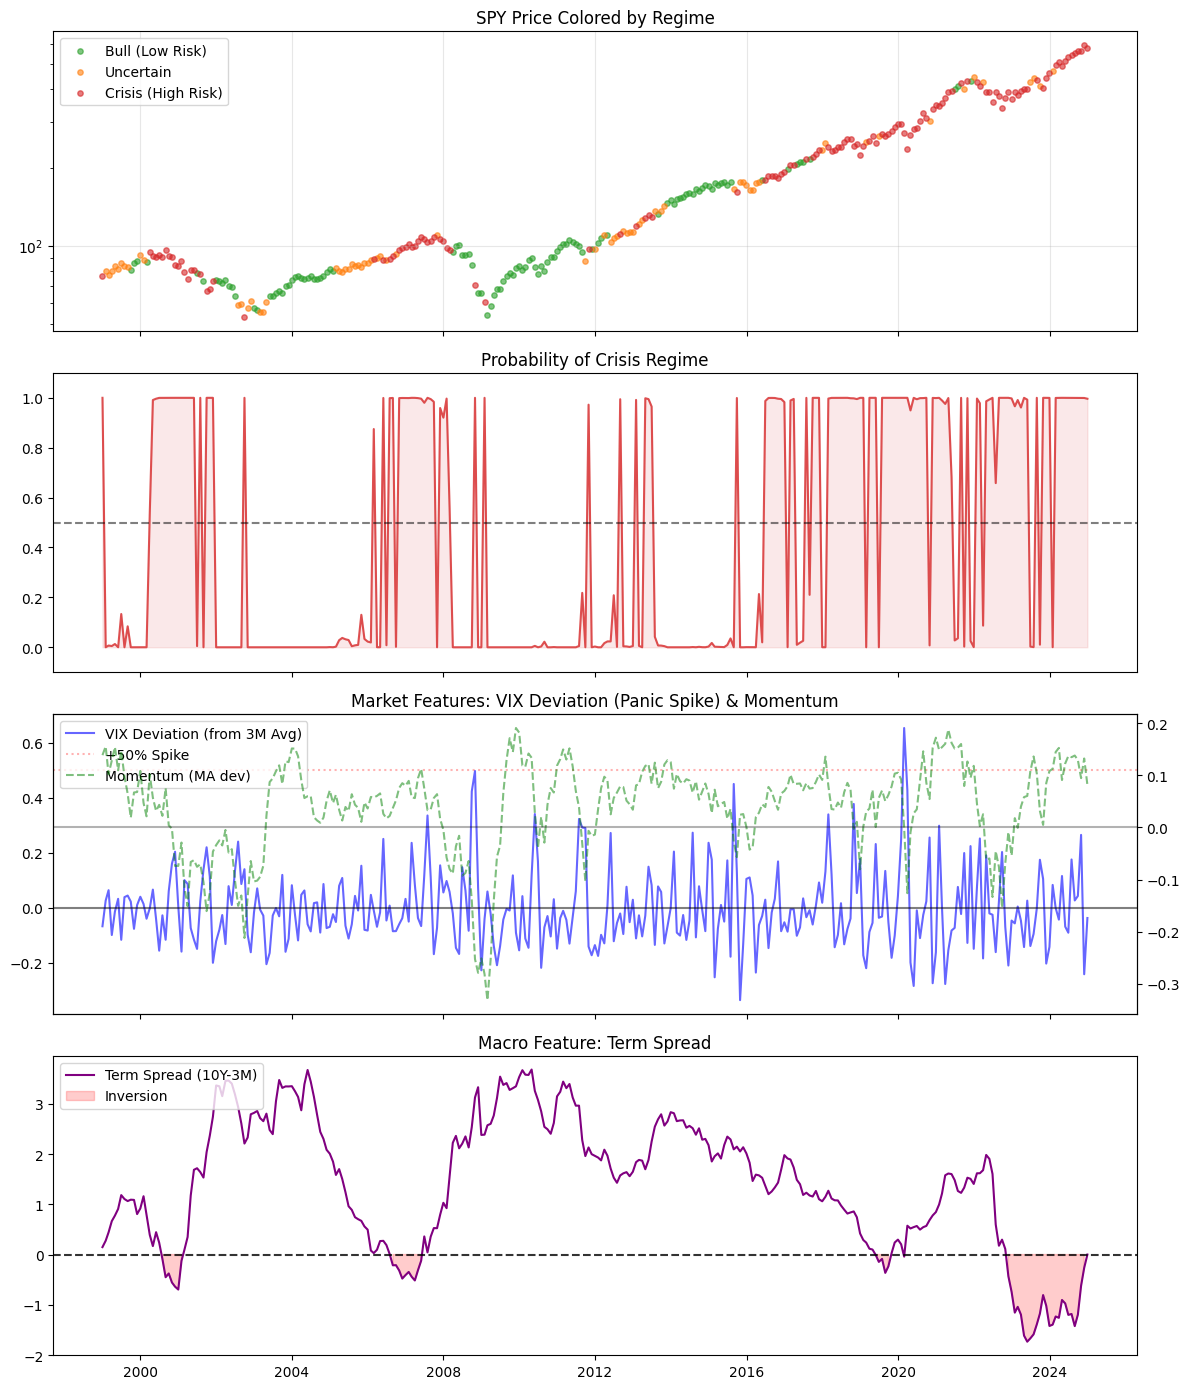

In [ ]:
#1
class RobustRegimeClassifier:
    def __init__(self, start_date='1990-01-01', end_date='2024-12-31', min_window=60):
        self.start_date = start_date
        self.end_date = end_date
        self.min_window = min_window
        self.n_states = 3  # 0:Bull, 1:Uncertain, 2:Crisis

    def fetch_data(self):
        print(">>> 1. Fetching Data (VIX Deviation, Momentum-MA, Term Spread)...")

        # A. Market Data (SPY, VIX) - VIX3M 제외
        tickers = ['SPY', '^VIX']
        try:
            data = yf.download(
                tickers,
                start=self.start_date,
                end=self.end_date,
                interval='1mo',
                progress=False,
                auto_adjust=True
            )

            # 멀티인덱스 컬럼 평탄화
            if isinstance(data.columns, pd.MultiIndex):
                try:
                    data = data['Close']
                except:
                    data.columns = data.columns.get_level_values(0)

            # 필수 데이터 확인
            if 'SPY' not in data.columns or '^VIX' not in data.columns:
                raise ValueError("Key market data (SPY or VIX) missing.")

        except Exception as e:
            print(f"!!! Error downloading market data: {e}")
            return pd.DataFrame()

        # 월말 기준 리샘플링
        data.index = pd.to_datetime(data.index)
        data = data.resample('ME').last()

        # Feature Engineering (Optimized)

        # 1. Momentum: 12개월 이동평균선(MA) 대비 이격도
        ma_12 = data['SPY'].rolling(window=12).mean()
        momentum = (data['SPY'] / ma_12) - 1

        # 2. VIX Deviation (New!): VIX의 최근 3개월(약 12주) 평균 대비 이격도
        # (VIX / 3-Month Moving Average of VIX) - 1
        # 양수(+)면 최근 평균보다 공포가 급등한 상태 -> 위기 신호
        vix_ma_3 = data['^VIX'].rolling(window=3).mean()
        vix_dev = (data['^VIX'] / vix_ma_3) - 1

        # B. Macro Data (T10Y3M)
        fred_tickers = ['T10Y3M']
        try:
            macro = web.DataReader(
                fred_tickers,
                'fred',
                self.start_date,
                self.end_date
            ).resample('ME').mean()
        except Exception as e:
            print(f"!!! Error downloading FRED data: {e}")
            return pd.DataFrame()

        # 데이터 병합
        df = pd.DataFrame({
            'SPY': data['SPY'],
            'VIX_Dev': vix_dev,  # Ratio 대신 Deviation 사용
            'Momentum': momentum
        })

        df = df.join(macro).ffill().dropna()

        # 초기 MA 계산 데이터 부족 구간 제거
        df = df.dropna()

        print(f"    Data Shape: {df.shape}")
        print(f"    Features used: VIX Deviation(vs 3M Avg), Momentum(MA dev), T10Y3M")
        return df

    def run_expanding_window_hmm(self, df):
        if df.empty:
            print("!!! Data is empty. Cannot run HMM.")
            return df

        print(">>> 2. Running Expanding Window HMM...")

        regime_preds = []
        prob_preds = []

        # 최종 사용 변수: VIX_Ratio -> VIX_Dev로 변경
        feature_cols = ['VIX_Dev', 'Momentum', 'T10Y3M']

        # Expanding Window Loop
        for t in tqdm(range(self.min_window, len(df))):
            train_data = df.iloc[:t + 1]
            X_train = train_data[feature_cols].values

            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds

            best_score = -np.inf
            best_model = None

            # Random Restarts
            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None
                    )
                    model.fit(X_scaled)
                    score = model.score(X_scaled)
                    if score > best_score:
                        best_score = score
                        best_model = model
                except:
                    continue

            if best_model is None:
                regime_preds.append(regime_preds[-1] if regime_preds else 0)
                prob_preds.append(prob_preds[-1] if prob_preds else np.zeros(self.n_states))
                continue

            current_prob = best_model.predict_proba(X_scaled)[-1]
            current_state = np.argmax(current_prob)

            # --- Dynamic State Re-ordering ---
            # 1. VIX Dev 높을수록 (공포 급등) -> 위기 (+)
            # 2. Momentum 낮을수록 -> 위기 (-)
            # 3. T10Y3M 낮을수록 -> 위기 (-)

            w_vix = 0.4
            w_mom = 0.3
            w_term = 0.3

            score_map = []
            for i in range(self.n_states):
                m = best_model.means_[i]
                # m[0]: VIX_Dev, m[1]: Momentum, m[2]: Term Spread
                risk_score = (w_vix * m[0]) - (w_mom * m[1]) - (w_term * m[2])
                score_map.append((i, risk_score))

            sorted_states = sorted(score_map, key=lambda x: x[1])
            state_mapping = {old: new for new, (old, _) in enumerate(sorted_states)}

            final_regime = state_mapping[current_state]

            sorted_probs = np.zeros(self.n_states)
            for old_idx, _ in sorted_states:
                sorted_probs[state_mapping[old_idx]] = current_prob[old_idx]

            regime_preds.append(final_regime)
            prob_preds.append(sorted_probs)

        # 결과 저장
        res_df = pd.DataFrame(index=df.index[self.min_window:])
        res_df['Regime'] = regime_preds

        prob_array = np.array(prob_preds)
        if len(prob_array) > 0:
            res_df['Prob_Bull'] = prob_array[:, 0]
            res_df['Prob_Uncertain'] = prob_array[:, 1]
            res_df['Prob_Crisis'] = prob_array[:, 2]

        return df.join(res_df).dropna()

    def visualize(self, df):
        if 'Regime' not in df.columns: return

        print(">>> 3. Visualizing Results...")
        fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

        colors = ['#2ca02c', '#ff7f0e', '#d62728']
        labels = ['Bull (Low Risk)', 'Uncertain', 'Crisis (High Risk)']

        # 1. Price
        for i in range(3):
            mask = df['Regime'] == i
            axes[0].scatter(df.index[mask], df['SPY'][mask],
                           c=colors[i], label=labels[i], s=15, alpha=0.6)
        axes[0].set_title('SPY Price Colored by Regime')
        axes[0].set_yscale('log')
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)

        # 2. Crisis Prob
        axes[1].plot(df.index, df['Prob_Crisis'], color='#d62728', alpha=0.8)
        axes[1].fill_between(df.index, 0, df['Prob_Crisis'], color='#d62728', alpha=0.1)
        axes[1].axhline(0.5, color='black', linestyle='--', alpha=0.5)
        axes[1].set_title('Probability of Crisis Regime')
        axes[1].set_ylim(-0.1, 1.1)

        # 3. Market Features: VIX Deviation & Momentum
        axes[2].plot(df.index, df['VIX_Dev'], color='blue', alpha=0.6, label='VIX Deviation (from 3M Avg)')
        axes[2].axhline(0.0, color='black', linestyle='-', alpha=0.5)
        axes[2].axhline(0.5, color='red', linestyle=':', alpha=0.3, label='+50% Spike')

        ax2_twin = axes[2].twinx()
        ax2_twin.plot(df.index, df['Momentum'], color='green', alpha=0.5, label='Momentum (MA dev)', linestyle='--')
        ax2_twin.axhline(0, color='black', alpha=0.3)

        axes[2].set_title('Market Features: VIX Deviation (Panic Spike) & Momentum')

        l1, lab1 = axes[2].get_legend_handles_labels()
        l2, lab2 = ax2_twin.get_legend_handles_labels()
        axes[2].legend(l1+l2, lab1+lab2, loc='upper left')

        # 4. Macro Feature
        axes[3].plot(df.index, df['T10Y3M'], color='purple', label='Term Spread (10Y-3M)')
        axes[3].axhline(0, color='black', linestyle='--', alpha=0.8)
        axes[3].fill_between(df.index, 0, df['T10Y3M'], where=(df['T10Y3M']<0), color='red', alpha=0.2, label='Inversion')
        axes[3].set_title('Macro Feature: Term Spread')
        axes[3].legend(loc='upper left')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    classifier = RobustRegimeClassifier()

    df1 = classifier.fetch_data()
    labeled_df1 = classifier.run_expanding_window_hmm(df1)
    classifier.visualize(labeled_df1)

>>> 1. Fetching Data (VIX Deviation, Momentum-MA, Credit Spread)...
    Data Shape: (373, 4)
    Features: VIX Deviation(vs 3M Avg), Momentum(MA dev), BAA10Y
>>> 2. Running Expanding Window HMM...


100%|██████████| 313/313 [01:17<00:00,  4.03it/s]


>>> 3. Visualizing Regimes...


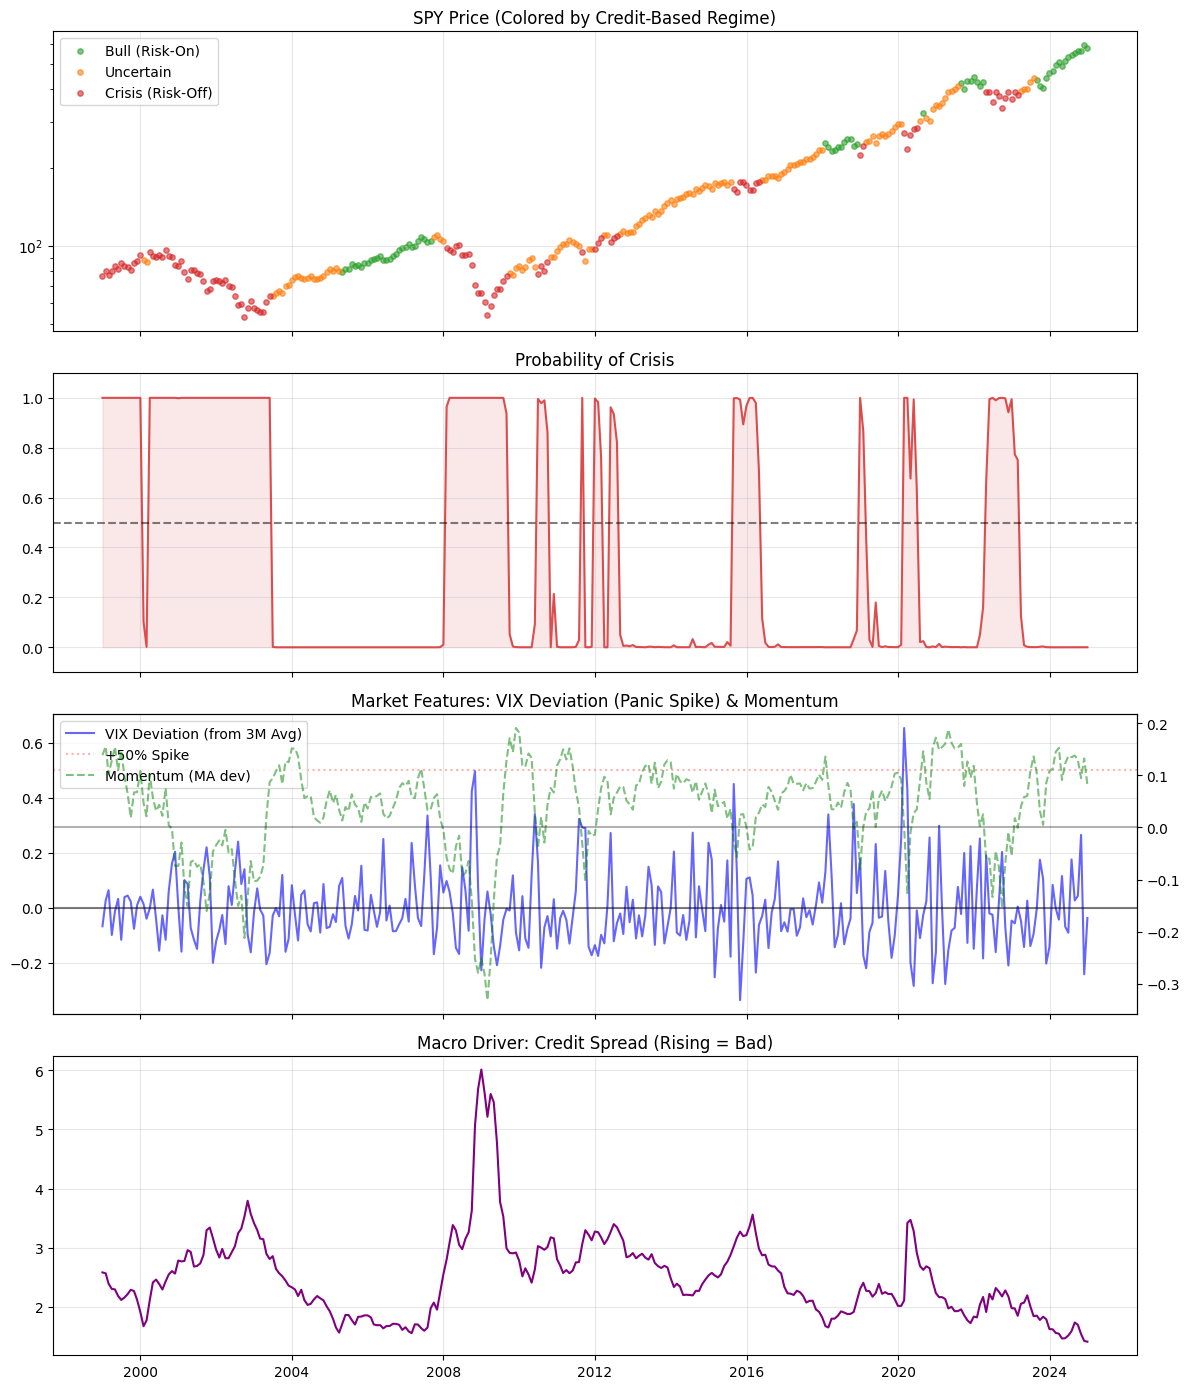

In [ ]:
#2
class RobustRegimeClassifier:
    def __init__(self, start_date='1990-01-01', end_date='2024-12-31', min_window=60):
        self.start_date = start_date
        self.end_date = end_date
        self.min_window = min_window
        self.n_states = 3   # 0:Bull, 1:Uncertain, 2:Crisis

    def fetch_data(self):
        print(">>> 1. Fetching Data (VIX Deviation, Momentum-MA, Credit Spread)...")

        # A. Market Data (SPY, VIX)
        tickers = ['SPY', '^VIX']
        try:
            data = yf.download(
                tickers,
                start=self.start_date,
                end=self.end_date,
                interval='1mo',
                progress=False,
                auto_adjust=True
            )

            # 멀티인덱스 컬럼 평탄화
            if isinstance(data.columns, pd.MultiIndex):
                try:
                    data = data['Close']
                except:
                    data.columns = data.columns.get_level_values(0)

            # 필수 데이터 확인
            if 'SPY' not in data.columns or '^VIX' not in data.columns:
                raise ValueError("Market data download failed or missing columns.")

        except Exception as e:
            print(f"!!! Error downloading market data: {e}")
            return pd.DataFrame()

        # 월말 리샘플링
        data.index = pd.to_datetime(data.index)
        data = data.resample('ME').last()

        # Feature Engineering (Optimized)

        # 1. Momentum: 12개월 이동평균선(MA) 이격도
        ma_12 = data['SPY'].rolling(window=12).mean()
        momentum = (data['SPY'] / ma_12) - 1

        # 2. VIX Deviation (New!): VIX의 최근 3개월(약 12주) 평균 대비 이격도
        # (VIX / 3-Month Moving Average of VIX) - 1
        # 양수(+)면 최근 평균보다 공포가 급등한 상태 -> 위기 신호
        vix_ma_3 = data['^VIX'].rolling(window=3).mean()
        vix_dev = (data['^VIX'] / vix_ma_3) - 1

        # B. Macro Data (Credit Spread - BAA10Y)
        fred_tickers = ['BAA10Y']
        try:
            macro = web.DataReader(
                fred_tickers,
                'fred',
                self.start_date,
                self.end_date
            ).resample('ME').mean()
        except Exception as e:
            print(f"!!! Error downloading FRED data (BAA10Y): {e}")
            return pd.DataFrame()

        # Merge
        df2 = pd.DataFrame({
            'SPY': data['SPY'],
            'VIX_Dev': vix_dev,    # VIX Ratio -> Deviation 변경
            'Momentum': momentum
        })

        df2 = df2.join(macro).ffill().dropna()

        # 초기 MA 계산 데이터 부족 구간 제거
        df2 = df2.dropna()

        if len(df2) < self.min_window:
            print(f"Warning: Not enough data ({len(df2)}) for min_window ({self.min_window})")
            return pd.DataFrame()

        print(f"    Data Shape: {df2.shape}")
        print(f"    Features: VIX Deviation(vs 3M Avg), Momentum(MA dev), BAA10Y")
        return df2

    def run_expanding_window_hmm(self, df2):
        if df2.empty:
            print("!!! Data is empty. Cannot run HMM.")
            return df2

        print(">>> 2. Running Expanding Window HMM...")

        regime_preds = []
        prob_preds = []

        # Feature 변경: VIX_Ratio -> VIX_Dev
        feature_cols = ['VIX_Dev', 'Momentum', 'BAA10Y']

        for t in tqdm(range(self.min_window, len(df2))):
            train_data = df2.iloc[:t + 1]
            X_train = train_data[feature_cols].values

            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds

            best_score = -np.inf
            best_model = None

            # Random Restarts
            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None
                    )
                    model.fit(X_scaled)
                    score = model.score(X_scaled)
                    if score > best_score:
                        best_score = score
                        best_model = model
                except:
                    continue

            if best_model is None:
                regime_preds.append(regime_preds[-1] if regime_preds else 0)
                prob_preds.append(prob_preds[-1] if prob_preds else np.zeros(self.n_states))
                continue

            current_prob = best_model.predict_proba(X_scaled)[-1]
            current_state = np.argmax(current_prob)

            # --- Dynamic State Re-ordering ---
            # Crisis Logic:
            # 1. VIX_Dev 높을수록 (공포 급등) -> 위험 (+)
            # 2. Momentum 낮을수록 -> 위험 (-)
            # 3. Credit Spread 높을수록 -> 위험 (+)

            state_scores = []
            w_vix = 0.4
            w_mom = 0.3
            w_credit = 0.3

            for i in range(self.n_states):
                m = best_model.means_[i]
                # m[0]: VIX_Dev, m[1]: Momentum, m[2]: BAA10Y
                risk_score = (w_vix * m[0]) - (w_mom * m[1]) + (w_credit * m[2])
                state_scores.append((i, risk_score))

            sorted_states = sorted(state_scores, key=lambda x: x[1])
            mapping = {old: new for new, (old, _) in enumerate(sorted_states)}

            final_regime = mapping[current_state]

            sorted_probs = np.zeros(self.n_states)
            for old_idx, _ in sorted_states:
                sorted_probs[mapping[old_idx]] = current_prob[old_idx]

            regime_preds.append(final_regime)
            prob_preds.append(sorted_probs)

        # 결과 저장
        res_df = pd.DataFrame(index=df2.index[self.min_window:])
        res_df['Regime'] = regime_preds

        prob_array = np.array(prob_preds)
        if len(prob_array) > 0:
            res_df['Prob_Bull'] = prob_array[:, 0]
            res_df['Prob_Uncertain'] = prob_array[:, 1]
            res_df['Prob_Crisis'] = prob_array[:, 2]

        return df2.join(res_df).dropna()

    def visualize(self, df2):
        if 'Regime' not in df2.columns: return

        print(">>> 3. Visualizing Regimes...")
        fig, ax = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

        colors = ['#2ca02c', '#ff7f0e', '#d62728']
        labels = ['Bull (Risk-On)', 'Uncertain', 'Crisis (Risk-Off)']

        # 1. Price
        for i in range(3):
            mask = df2['Regime'] == i
            ax[0].scatter(df2.index[mask], df2['SPY'][mask], s=15, c=colors[i], label=labels[i], alpha=0.6)
        ax[0].set_title('SPY Price (Colored by Credit-Based Regime)')
        ax[0].set_yscale('log')
        ax[0].legend(loc='upper left')
        ax[0].grid(True, alpha=0.3)

        # 2. Crisis Prob
        ax[1].plot(df2.index, df2['Prob_Crisis'], color='#d62728', alpha=0.8)
        ax[1].fill_between(df2.index, 0, df2['Prob_Crisis'], color='#d62728', alpha=0.1)
        ax[1].axhline(0.5, linestyle='--', color='black', alpha=0.5)
        ax[1].set_title('Probability of Crisis')
        ax[1].set_ylim(-0.1, 1.1)
        ax[1].grid(True, alpha=0.3)

        # 3. Features: VIX Deviation & Momentum
        ax[2].plot(df2.index, df2['VIX_Dev'], color='blue', alpha=0.6, label='VIX Deviation (from 3M Avg)')
        ax[2].axhline(0.0, color='black', linestyle='-', alpha=0.5)
        ax[2].axhline(0.5, color='red', linestyle=':', alpha=0.3, label='+50% Spike')

        ax2_twin = ax[2].twinx()
        ax2_twin.plot(df2.index, df2['Momentum'], color='green', alpha=0.5, label='Momentum (MA dev)', linestyle='--')
        ax2_twin.axhline(0, color='black', alpha=0.3)

        ax[2].set_title('Market Features: VIX Deviation (Panic Spike) & Momentum')

        l1, lab1 = ax[2].get_legend_handles_labels()
        l2, lab2 = ax2_twin.get_legend_handles_labels()
        ax[2].legend(l1+l2, lab1+lab2, loc='upper left')
        ax[2].grid(True, alpha=0.3)

        # 4. Feature: Credit Spread
        ax[3].plot(df2.index, df2['BAA10Y'], color='purple', label='Credit Spread (BAA10Y)')
        ax[3].set_title('Macro Driver: Credit Spread (Rising = Bad)')
        ax[3].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    classifier = RobustRegimeClassifier()
    df2 = classifier.fetch_data()

    if not df2.empty:
        labeled_df2 = classifier.run_expanding_window_hmm(df2)
        classifier.visualize(labeled_df2)

>>> 1. Fetching Data (VIX Deviation, Momentum-MA, Credit Spread)...
    Data Shape: (373, 4)
    Features: VIX Deviation(vs 3M Avg), Momentum(MA dev), BAA10Y
>>> 2. Running Expanding Window HMM...


100%|██████████| 313/313 [00:43<00:00,  7.12it/s]


>>> 3. Visualizing Binary Regimes...


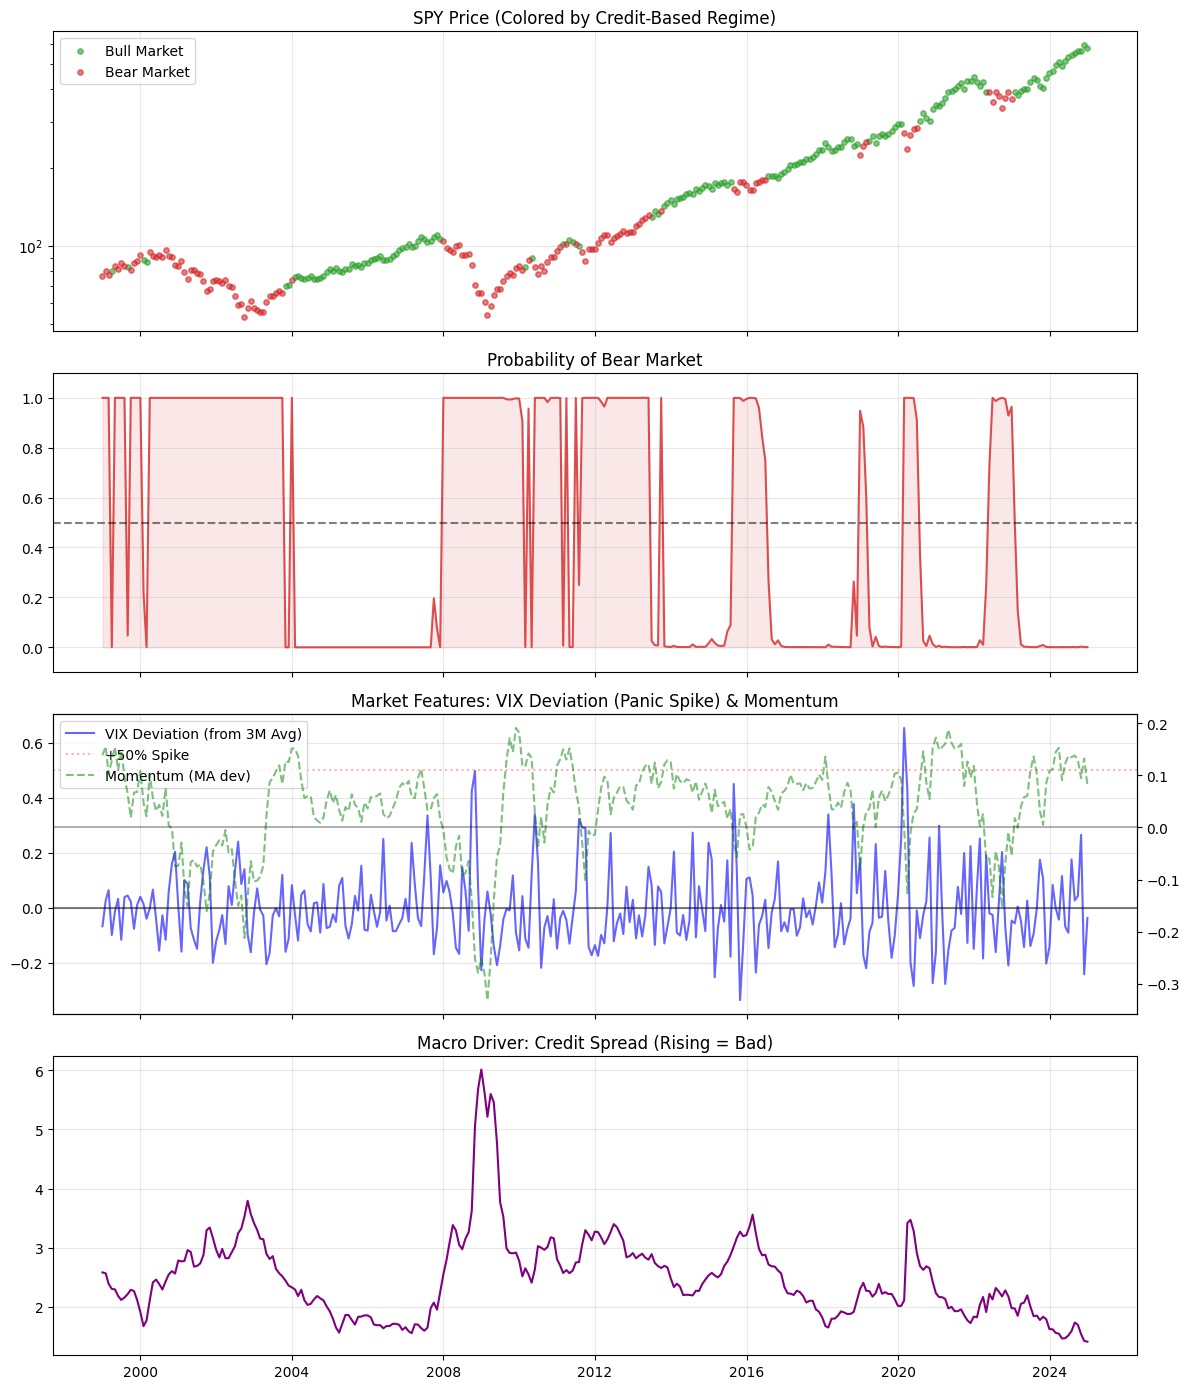

In [ ]:
#3
class RobustRegimeClassifier:
    def __init__(self, start_date='1990-01-01', end_date='2024-12-31', min_window=60):
        self.start_date = start_date
        self.end_date = end_date
        self.min_window = min_window
        self.n_states = 2  # 0:Bull, 1:Bear (2분할 모델)

    def fetch_data(self):
        print(">>> 1. Fetching Data (VIX Deviation, Momentum-MA, Credit Spread)...")

        # A. Market Data (SPY, VIX)
        tickers = ['SPY', '^VIX']
        try:
            data = yf.download(
                tickers,
                start=self.start_date,
                end=self.end_date,
                interval='1mo',
                progress=False,
                auto_adjust=True
            )

            # 멀티인덱스 컬럼 평탄화
            if isinstance(data.columns, pd.MultiIndex):
                try:
                    data = data['Close']
                except:
                    data.columns = data.columns.get_level_values(0)

            # 필수 데이터 확인
            if 'SPY' not in data.columns or '^VIX' not in data.columns:
                raise ValueError("Market data download failed or missing columns.")

        except Exception as e:
            print(f"!!! Error downloading market data: {e}")
            return pd.DataFrame()

        # 월말 리샘플링
        data.index = pd.to_datetime(data.index)
        data = data.resample('ME').last()

        # Feature Engineering (Optimized)

        # 1. Momentum: 12개월 이동평균선(MA) 이격도
        ma_12 = data['SPY'].rolling(window=12).mean()
        momentum = (data['SPY'] / ma_12) - 1

        # 2. VIX Deviation (New!): VIX의 최근 3개월(약 12주) 평균 대비 이격도
        # (VIX / 3-Month Moving Average of VIX) - 1
        # 양수(+)면 최근 평균보다 공포가 급등한 상태 -> Bear Signal
        vix_ma_3 = data['^VIX'].rolling(window=3).mean()
        vix_dev = (data['^VIX'] / vix_ma_3) - 1

        # B. Macro Data (Credit Spread - BAA10Y)
        fred_tickers = ['BAA10Y']
        try:
            macro = web.DataReader(
                fred_tickers,
                'fred',
                self.start_date,
                self.end_date
            ).resample('ME').mean()
        except Exception as e:
            print(f"!!! Error downloading FRED data (BAA10Y): {e}")
            return pd.DataFrame()

        # Merge
        df2 = pd.DataFrame({
            'SPY': data['SPY'],
            'VIX_Dev': vix_dev,    # VIX Ratio -> Deviation 변경
            'Momentum': momentum
        })

        df2 = df2.join(macro).ffill().dropna()

        # 초기 MA 계산 데이터 부족 구간 제거
        df2 = df2.dropna()

        if len(df2) < self.min_window:
            print(f"Warning: Not enough data ({len(df2)}) for min_window ({self.min_window})")
            return pd.DataFrame()

        print(f"    Data Shape: {df2.shape}")
        print(f"    Features: VIX Deviation(vs 3M Avg), Momentum(MA dev), BAA10Y")
        return df2

    def run_expanding_window_hmm(self, df2):
        if df2.empty:
            print("!!! Data is empty. Cannot run HMM.")
            return df2

        print(">>> 2. Running Expanding Window HMM...")

        regime_preds = []
        prob_preds = []

        # Feature 변경: VIX_Ratio -> VIX_Dev
        feature_cols = ['VIX_Dev', 'Momentum', 'BAA10Y']

        for t in tqdm(range(self.min_window, len(df2))):
            train_data = df2.iloc[:t + 1]
            X_train = train_data[feature_cols].values

            # Standardization
            means = X_train.mean(axis=0)
            stds = X_train.std(axis=0) + 1e-6
            X_scaled = (X_train - means) / stds

            best_score = -np.inf
            best_model = None

            # Random Restarts
            for _ in range(5):
                try:
                    model = GaussianHMM(
                        n_components=self.n_states,
                        covariance_type="diag",
                        n_iter=1000,
                        tol=1e-4,
                        min_covar=1e-3,
                        random_state=None
                    )
                    model.fit(X_scaled)
                    score = model.score(X_scaled)
                    if score > best_score:
                        best_score = score
                        best_model = model
                except:
                    continue

            if best_model is None:
                regime_preds.append(regime_preds[-1] if regime_preds else 0)
                prob_preds.append(prob_preds[-1] if prob_preds else np.zeros(self.n_states))
                continue

            current_prob = best_model.predict_proba(X_scaled)[-1]
            current_state = np.argmax(current_prob)

            # --- Dynamic State Re-ordering ---
            # Bear Market(1) Condition:
            # 1. VIX_Dev 높을수록 (공포 급등) -> Bear (+)
            # 2. Momentum 낮을수록 -> Bear (-)
            # 3. Credit Spread 높을수록 -> Bear (+)

            state_scores = []
            w_vix = 0.4
            w_mom = 0.3
            w_credit = 0.3

            for i in range(self.n_states):
                m = best_model.means_[i]
                # m[0]: VIX_Dev, m[1]: Momentum, m[2]: BAA10Y
                risk_score = (w_vix * m[0]) - (w_mom * m[1]) + (w_credit * m[2])
                state_scores.append((i, risk_score))

            # 정렬 (0:Bull -> 1:Bear)
            sorted_states = sorted(state_scores, key=lambda x: x[1])
            mapping = {old: new for new, (old, _) in enumerate(sorted_states)}

            final_regime = mapping[current_state]

            sorted_probs = np.zeros(self.n_states)
            for old_idx, _ in sorted_states:
                sorted_probs[mapping[old_idx]] = current_prob[old_idx]

            regime_preds.append(final_regime)
            prob_preds.append(sorted_probs)

        # 결과 저장
        res_df = pd.DataFrame(index=df2.index[self.min_window:])
        res_df['Regime'] = regime_preds

        prob_array = np.array(prob_preds)
        if len(prob_array) > 0:
            res_df['Prob_Bull'] = prob_array[:, 0]
            res_df['Prob_Bear'] = prob_array[:, 1]

        return df2.join(res_df).dropna()

    def visualize(self, df2):
        if 'Regime' not in df2.columns: return

        print(">>> 3. Visualizing Binary Regimes...")
        fig, ax = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

        colors = ['#2ca02c', '#d62728'] # Green: Bull, Red: Bear
        labels = ['Bull Market', 'Bear Market']

        # 1. Price
        for i in range(2):
            mask = df2['Regime'] == i
            ax[0].scatter(df2.index[mask], df2['SPY'][mask], s=15, c=colors[i], label=labels[i], alpha=0.6)
        ax[0].set_title('SPY Price (Colored by Credit-Based Regime)')
        ax[0].set_yscale('log')
        ax[0].legend(loc='upper left')
        ax[0].grid(True, alpha=0.3)

        # 2. Bear Prob
        ax[1].plot(df2.index, df2['Prob_Bear'], color='#d62728', alpha=0.8)
        ax[1].fill_between(df2.index, 0, df2['Prob_Bear'], color='#d62728', alpha=0.1)
        ax[1].axhline(0.5, linestyle='--', color='black', alpha=0.5)
        ax[1].set_title('Probability of Bear Market')
        ax[1].set_ylim(-0.1, 1.1)
        ax[1].grid(True, alpha=0.3)

        # 3. Features: VIX Deviation & Momentum
        ax[2].plot(df2.index, df2['VIX_Dev'], color='blue', alpha=0.6, label='VIX Deviation (from 3M Avg)')
        ax[2].axhline(0.0, color='black', linestyle='-', alpha=0.5)
        ax[2].axhline(0.5, color='red', linestyle=':', alpha=0.3, label='+50% Spike')

        ax2_twin = ax[2].twinx()
        ax2_twin.plot(df2.index, df2['Momentum'], color='green', alpha=0.5, label='Momentum (MA dev)', linestyle='--')
        ax2_twin.axhline(0, color='black', alpha=0.3)

        ax[2].set_title('Market Features: VIX Deviation (Panic Spike) & Momentum')
        l1, lab1 = ax[2].get_legend_handles_labels()
        l2, lab2 = ax2_twin.get_legend_handles_labels()
        ax[2].legend(l1+l2, lab1+lab2, loc='upper left')
        ax[2].grid(True, alpha=0.3)

        # 4. Feature: Credit Spread
        ax[3].plot(df2.index, df2['BAA10Y'], color='purple', label='Credit Spread (BAA10Y)')
        ax[3].set_title('Macro Driver: Credit Spread (Rising = Bad)')
        ax[3].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    classifier = RobustRegimeClassifier()
    df3 = classifier.fetch_data()

    if not df2.empty:
        labeled_df3 = classifier.run_expanding_window_hmm(df3)
        classifier.visualize(labeled_df3)

>>> [Model 4] 실행 및 데이터 갱신 중...
--- [Binary Model] 데이터 수집 (1990-01-01 ~ 2024-12-31) ---


/tmp/ipython-input-1391053499.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_stock = yf.download(
/tmp/ipython-input-1391053499.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly['SP500'] = df_daily['Close'].resample('M').last()
/tmp/ipython-input-1391053499.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly['VIX'] = df_daily['VIXCLS'].resample('M').mean()
/tmp/ipython-input-1391053499.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly['Yield_Spread'] = df_daily['T10Y2Y'].resample('M').mean()


 -> 데이터 확보 완료: 384개월

--- [Performance Check: 2-State Model] ---
               count  Ann_Return  Sharpe
Regime                                  
Bear (Cash)       65        1.75    0.08
Bull (Equity)    283       12.84    1.00


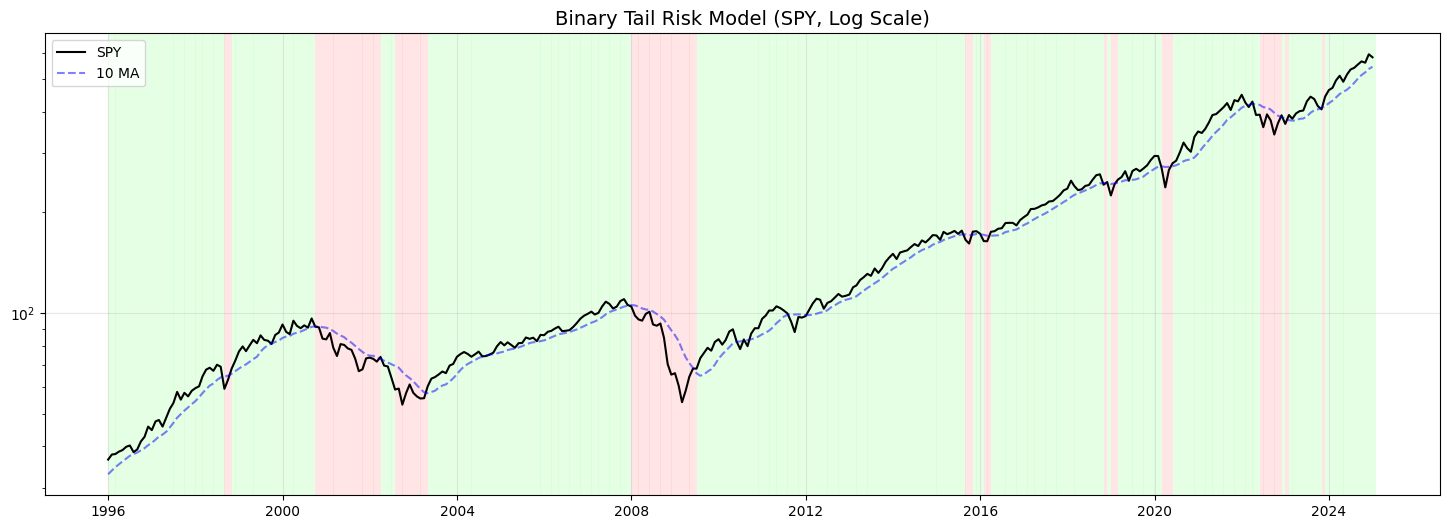

In [ ]:
#4
class BinaryRegimePipe:
    """
    [Binary Version]
    - Data: yfinance (Price) + FRED (Macro)
    - Logic: 2-State (Risk-On vs Risk-Off)
    - Philosophy: Remove 'Sideways'. Treat minor dips as noise (Stay Bull).
                  Only switch to Bear on 'Confirmed' signals.
    """
    def __init__(self, start_date='1990-01-01'):
        self.start = start_date
        self.end = '2024-12-31'
        self.df4 = pd.DataFrame()

    def fetch_data(self):
        print(f"--- [Binary Model] 데이터 수집 ({self.start} ~ {self.end}) ---")
        try:
            # 1. Price (yfinance)
            df_stock = yf.download(
                'SPY',
                start=self.start,
                end=self.end,
                progress=False
            )

            # 🔧 MultiIndex 컬럼 평탄화 (핵심)
            if isinstance(df_stock.columns, pd.MultiIndex):
                df_stock.columns = df_stock.columns.get_level_values(0)

            # Adj Close 우선, 없으면 Close
            if 'Adj Close' in df_stock.columns:
                df_stock = df_stock[['Adj Close']].rename(columns={'Adj Close': 'Close'})
            elif 'Close' in df_stock.columns:
                df_stock = df_stock[['Close']]
            else:
                raise ValueError("No Close or Adj Close column in yfinance data")

            # 2. Macro (FRED)
            df_macro = web.DataReader(
                ['VIXCLS', 'T10Y2Y'],
                'fred',
                self.start,
                self.end
            )

            # Index 정리
            df_stock.index = pd.to_datetime(df_stock.index)
            df_macro.index = pd.to_datetime(df_macro.index)

            # Daily Merge -> Monthly Resample
            df_daily = pd.concat([df_stock['Close'], df_macro], axis=1).ffill()

            df_monthly = pd.DataFrame()
            df_monthly['SP500'] = df_daily['Close'].resample('M').last()
            df_monthly['VIX'] = df_daily['VIXCLS'].resample('M').mean()
            df_monthly['Yield_Spread'] = df_daily['T10Y2Y'].resample('M').mean()

            self.df4 = df_monthly.dropna()
            print(f" -> 데이터 확보 완료: {len(self.df4)}개월")
            return self.df4

        except Exception as e:
            print(f"Error: {e}")
            return pd.DataFrame()

    def apply_binary_logic(self):
        if self.df4.empty:
            return

        self.df4['MA_10'] = self.df4['SP500'].rolling(window=10).mean()
        self.df4['VIX_Threshold'] = self.df4['VIX'].rolling(window=36).quantile(0.80)

        data = self.df4.dropna().copy()
        regimes = []
        current_state = 1

        for i in range(len(data)):
            row = data.iloc[i]

            is_uptrend = row['SP500'] > row['MA_10']
            is_fear = row['VIX'] > row['VIX_Threshold']
            is_inverted = row['Yield_Spread'] < 0.0

            next_state = current_state

            if current_state == 1:
                if not is_uptrend and (is_fear or is_inverted):
                    next_state = 0
            else:
                if is_uptrend:
                    next_state = 1

            regimes.append(next_state)
            current_state = next_state

        data['Regime'] = regimes
        self.df4 = data
        return self.df4

    def validate_performance(self):
        if 'Regime' not in self.df4.columns:
            return

        self.df4['Next_Ret'] = self.df4['SP500'].pct_change().shift(-1)

        print("\n--- [Performance Check: 2-State Model] ---")
        stats = self.df4.groupby('Regime')['Next_Ret'].agg(['count', 'mean', 'std'])

        stats['Ann_Return'] = stats['mean'] * 12 * 100
        stats['Ann_Vol'] = stats['std'] * (12 ** 0.5) * 100
        stats['Sharpe'] = stats['Ann_Return'] / stats['Ann_Vol']

        label_map = {0: 'Bear (Cash)', 1: 'Bull (Equity)'}
        stats.index = stats.index.map(label_map)

        print(stats[['count', 'Ann_Return', 'Sharpe']].round(2))
        return stats

    def visualize(self):
        if self.df4.empty:
            return

        df4 = self.df4
        plt.figure(figsize=(18, 6))

        plt.plot(df4.index, df4['SP500'],
                 color='black', linewidth=1.5, label='SPY')

        plt.plot(df4.index, df4['MA_10'],
                 color='blue', linestyle='--', alpha=0.5, label='10 MA')

        colors = {0: '#ffcccc', 1: '#ccffcc'}

        for i in range(len(df4)):
            date = df4.index[i]
            state = df4['Regime'].iloc[i]
            plt.axvspan(
                date,
                date + pd.Timedelta(days=32),
                facecolor=colors[state],
                edgecolor='none',
                alpha=0.5
            )

        plt.title('Binary Tail Risk Model (SPY, Log Scale)', fontsize=14)
        plt.yscale('log')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()


if __name__ == "__main__":
    print(">>> [Model 4] 실행 및 데이터 갱신 중...")

    pipe = BinaryRegimePipe()
    raw_data = pipe.fetch_data()
    df4 = pipe.apply_binary_logic()
    pipe.validate_performance()
    pipe.visualize()


>>> [Regime Comparison] Aligning data and calculating statistics...

[Statistical Evaluation vs Rule-Based]
1. Term_3S   -> Mismatch: 40.89% | Kappa: 0.102
2. Credit_3S -> Mismatch: 16.93% | Kappa: 0.588
3. Credit_2S -> Mismatch: 26.84% | Kappa: 0.434


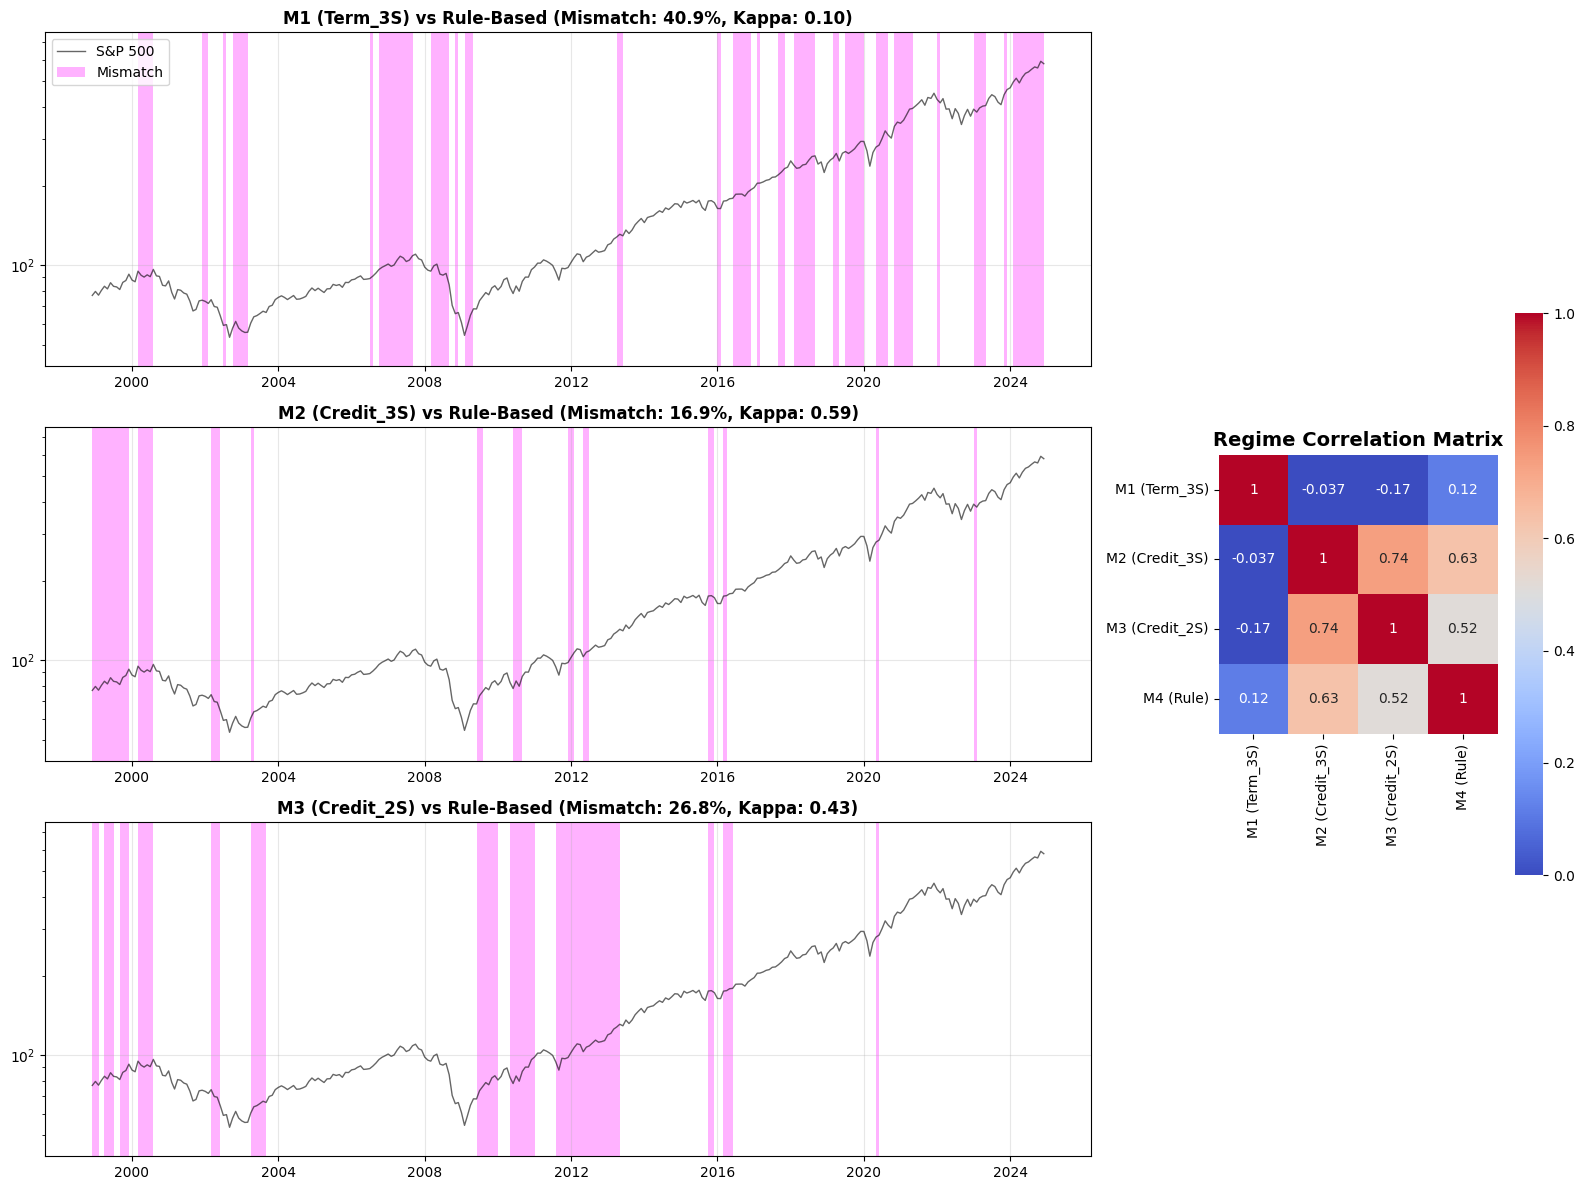

In [ ]:
def run_advanced_comparison(df1, df2, df3, df4):
    print(">>> [Regime Comparison] Aligning data and calculating statistics...")

    # 데이터 유효성 체크
    if any(df is None or df.empty for df in [df1, df2, df3, df4]):
        print("Error: 입력된 데이터프레임 중 일부가 비어있습니다.")
        return

    # --- 1. 데이터 인덱스 통일 (Timezone 제거 & 월초 기준) ---
    # 원본 보호를 위해 복사
    d1, d2, d3, d4 = df1.copy(), df2.copy(), df3.copy(), df4.copy()

    dfs = [d1, d2, d3, d4]

    # [핵심 수정] Timezone 강제 제거 및 날짜 포맷 통일
    for i, df in enumerate(dfs):
        # 1. Timezone 정보가 있다면 강제로 제거 (None으로 설정)
        if df.index.tz is not None:
            df.index = df.index.tz_localize(None)

        # 2. 모든 날짜를 해당 월의 1일로 강제 통일 (예: 1월 31일 -> 1월 1일)
        df.index = df.index.to_period('M').to_timestamp()

    # 공통 기간 추출
    common_idx = d1.index.intersection(d2.index).intersection(d3.index).intersection(d4.index)

    if len(common_idx) == 0:
        print("Error: 공통된 기간이 없습니다. (교집합 0개)")
        print(f"Data 1 기간: {d1.index[0]} ~ {d1.index[-1]}")
        print(f"Data 4 기간: {d4.index[0]} ~ {d4.index[-1]}")
        return

    # 데이터 자르기
    d1, d2, d3, d4 = d1.loc[common_idx], d2.loc[common_idx], d3.loc[common_idx], d4.loc[common_idx]

    # --- 2. Regime Binary 변환 (1=Bull, 0=Bear) ---
    # Model 1 (3-State Term): State 2(Crisis)만 Bear(0), 나머지 Bull(1)
    s1 = d1['Regime'].apply(lambda x: 0 if x == 2 else 1)

    # Model 2 (3-State Credit): State 2(Crisis)만 Bear(0), 나머지 Bull(1)
    s2 = d2['Regime'].apply(lambda x: 0 if x == 2 else 1)

    # Model 3 (2-State Credit): 0:Bull, 1:Bear -> 1, 0으로 변환
    s3 = d3['Regime'].apply(lambda x: 0 if x == 1 else 1)

    # Model 4 (Rule-Based): 이미 1:Bull, 0:Bear
    s4 = d4['Regime']

    # 통합 DataFrame
    comp_df = pd.DataFrame({
        'Price': d4['SP500'] if 'SP500' in d4.columns else d4.iloc[:, 0], # 컬럼명 방어코드
        'M1 (Term_3S)': s1,
        'M2 (Credit_3S)': s2,
        'M3 (Credit_2S)': s3,
        'M4 (Rule)': s4
    })

    # --- 3. 통계적 분석 (상관관계 & Kappa) ---
    # 상관관계 행렬
    corr_matrix = comp_df[['M1 (Term_3S)', 'M2 (Credit_3S)', 'M3 (Credit_2S)', 'M4 (Rule)']].corr()

    # Cohen's Kappa
    k1 = cohen_kappa_score(s4, s1)
    k2 = cohen_kappa_score(s4, s2)
    k3 = cohen_kappa_score(s4, s3)

    # 불일치율 계산
    mis_1 = (s1 != s4).mean() * 100
    mis_2 = (s2 != s4).mean() * 100
    mis_3 = (s3 != s4).mean() * 100

    print(f"\n[Statistical Evaluation vs Rule-Based]")
    print(f"1. Term_3S   -> Mismatch: {mis_1:5.2f}% | Kappa: {k1:.3f}")
    print(f"2. Credit_3S -> Mismatch: {mis_2:5.2f}% | Kappa: {k2:.3f}")
    print(f"3. Credit_2S -> Mismatch: {mis_3:5.2f}% | Kappa: {k3:.3f}")

    # --- 4. 시각화 ---
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, width_ratios=[3, 1])

    models = [
        ('M1 (Term_3S)', mis_1, k1),
        ('M2 (Credit_3S)', mis_2, k2),
        ('M3 (Credit_2S)', mis_3, k3)
    ]

    for i, (col, mis, k) in enumerate(models):
        ax = fig.add_subplot(gs[i, 0])

        # 주가
        ax.plot(comp_df.index, comp_df['Price'], color='black', lw=1, alpha=0.6, label='S&P 500')
        ax.set_yscale('log')

        # 불일치 구간 (Magenta Area)
        mismatch_mask = comp_df[col] != comp_df['M4 (Rule)']

        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

        ax.fill_between(comp_df.index, 0, 1, where=mismatch_mask,
                        facecolor='magenta', alpha=0.3, transform=trans, label='Mismatch')

        ax.set_title(f"{col} vs Rule-Based (Mismatch: {mis:.1f}%, Kappa: {k:.2f})", fontweight='bold')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend(loc='upper left')

    # 상관관계 히트맵
    ax_heat = fig.add_subplot(gs[:, 1])
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, square=True, ax=ax_heat, cbar_kws={"shrink": .5})
    ax_heat.set_title("Regime Correlation Matrix", fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# --- 실행 ---
if __name__ == "__main__":
        run_advanced_comparison(labeled_df1, labeled_df2, labeled_df3, df4)